In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.fft import fftn, ifftn, next_fast_len
from scipy.sparse import diags
from scipy.stats import wasserstein_distance
import warnings
import copy
import os
import matplotlib.pyplot as plt

# --- Set a default plotting style ---
plt.style.use('seaborn-v0_8-whitegrid')

# ==============================================================================
# SECTION 1: N-DIMENSIONAL PDE SOLVER (Unchanged)
# ==============================================================================

default_params_nd = {
        "nx": 50, "bord": 5, "T": 100,
        "mu": 4e-3, "gamma": 0.3, 'eta': 1e-3,
        "r_v": 1, "alpha": 0.025, "beta": 0.025,
        "K_cap": 1e8, "kappa": 1e-7, "sigma": 1,
        "V0_total": 1e6, "v_init_pos": [1, 1],
        "D0_total": 1e6, "d_init_pos": [1.4, 0],
        "init_spread": 0.4, "monitor_extinction": True,
        "extinction_threshold_V": 1e2, "extinction_threshold_D": 1e2,
        "save_density_series": False,
}

def event_virus_extinction_nd(t, Q, *args):
    params = args[-1]
    n_dims, dx, grid_size = params['n_dims'], params['dx'], params['grid_size']
    current_V_total = np.sum(np.maximum(0, Q[:grid_size])) * (dx**n_dims)
    return current_V_total - params.get('extinction_threshold_V', 1e-2)
event_virus_extinction_nd.terminal = True
event_virus_extinction_nd.direction = -1

def event_dip_extinction_nd(t, Q, *args):
    params = args[-1]
    n_dims, dx, grid_size = params['n_dims'], params['dx'], params['grid_size']
    current_D_total = np.sum(np.maximum(0, Q[grid_size:])) * (dx**n_dims)
    return current_D_total - params.get('extinction_threshold_D', 1e-2)
event_dip_extinction_nd.terminal = False
event_dip_extinction_nd.direction = -1

def create_nd_coordinates(n_dims, nx, bord):
    dx = (2.0 * bord) / nx
    centers = np.linspace(-bord + dx/2, bord - dx/2, nx)
    coords = np.meshgrid(*[centers for _ in range(n_dims)], indexing='ij')
    return coords, dx, centers

def create_nd_diffusion_operators(nx, dx):
    A_1D = diags([-2, 1, 1], [0, -1, 1], shape=(nx, nx)).toarray()
    A_1D[0, 1] = 2; A_1D[-1, -2] = 2
    return A_1D / dx**2

def create_nd_fft_kernel_padded(dx, sigma, n_dims, padded_shape):
    if sigma <= 1e-9: return np.ones(padded_shape, dtype=complex)
    padded_indices = [np.arange(s) for s in padded_shape]
    padded_grids = np.meshgrid(*padded_indices, indexing='ij')
    dist_sq = np.zeros(padded_shape)
    for i in range(n_dims):
        dist_dim = np.minimum(padded_grids[i], padded_shape[i] - padded_grids[i]) * dx
        dist_sq += dist_dim**2
    kernel = np.exp(-dist_sq / (2 * sigma**2))
    kernel_sum = np.sum(kernel) * (dx**n_dims)
    if kernel_sum > 1e-9: kernel /= kernel_sum
    return fftn(kernel)

def create_nd_initial_conditions(centers, coords, init_pos, total_mass, init_spread, dx, n_dims):
    if len(init_pos) < n_dims: init_pos = list(init_pos) + [0] * (n_dims - len(init_pos))
    elif len(init_pos) > n_dims: init_pos = init_pos[:n_dims]
    grid_shape = tuple([len(centers)] * n_dims)
    if init_spread < (dx / 2):
        init_density = np.zeros(grid_shape)
        indices = tuple(np.argmin(np.abs(centers - init_pos[i])) for i in range(n_dims))
        init_density[indices] = total_mass / (dx**n_dims)
        return init_density
    else:
        dist_sq = np.zeros_like(coords[0])
        for i in range(n_dims): dist_sq += (coords[i] - init_pos[i])**2
        init_gauss = np.exp(-dist_sq / (2 * init_spread**2))
        normalization = np.sum(init_gauss) * (dx**n_dims)
        return init_gauss * (total_mass / max(normalization, 1e-12))

def calculate_nd_stats(density, coords, dx, n_dims, min_total=1e-9):
    total_mass = np.sum(density) * (dx**n_dims)
    if total_mass < min_total: return {'mean': [np.nan] * n_dims}
    prob_density = density / np.sum(density)
    mean = [np.sum(coords[i] * prob_density) for i in range(n_dims)]
    return {'mean': mean}

def nd_pde_system_corrected(t, Q, diffusion_op, coords, fft_kernel, params):
    n_dims, nx, grid_shape, padded_shape = params['n_dims'], params['nx'], params['grid_shape'], params['padded_shape']
    grid_size, dx = params['grid_size'], params['dx']
    mu, K_cap, kappa, gamma, eta = params["mu"], params["K_cap"], params["kappa"], params["gamma"], params['eta']
    r_v, alpha, beta = params["r_v"], params["alpha"], params["beta"]
    v_density = np.maximum(0, Q[:grid_size]).reshape(grid_shape)
    d_density = np.maximum(0, Q[grid_size:]).reshape(grid_shape)
    V_total = np.sum(v_density) * (dx**n_dims)
    D_total = np.sum(d_density) * (dx**n_dims)
    xbarV = [np.sum(coords[i] * v_density) * (dx**n_dims) / V_total if V_total > 1e-9 else 0.0 for i in range(n_dims)]
    logistic_factor = (1 - (V_total + D_total) / max(K_cap, 1e-12))
    v_padded = np.zeros(padded_shape); d_padded = np.zeros(padded_shape)
    original_slice = tuple(slice(0, s) for s in grid_shape)
    v_padded[original_slice] = v_density; d_padded[original_slice] = d_density
    conv_v = np.real(ifftn(fft_kernel * fftn(v_padded)))[original_slice]
    conv_d = np.real(ifftn(fft_kernel * fftn(d_padded)))[original_slice]
    interference_on_v = kappa * conv_d
    interference_for_d = kappa * conv_v
    phenotype_cost = np.sum([coords[i]**2 for i in range(n_dims)], axis=0)
    frequency_cost = np.sum([(coords[i] - xbarV[i])**2 for i in range(n_dims)], axis=0)
    r_v_map = r_v - eta - alpha * phenotype_cost - beta * frequency_cost
    dv_dt_diffusion = sum(mu * np.apply_along_axis(lambda x: diffusion_op @ x, i, v_density) for i in range(n_dims))
    dd_dt_diffusion = sum(mu * np.apply_along_axis(lambda x: diffusion_op @ x, i, d_density) for i in range(n_dims))
    dv_dt_growth = (r_v_map * v_density - v_density * interference_on_v) * logistic_factor - gamma * v_density
    dd_dt_growth = (d_density * interference_for_d + eta * v_density) * logistic_factor - gamma * d_density
    dv_dt = dv_dt_diffusion + dv_dt_growth
    dd_dt = dd_dt_diffusion + dd_dt_growth
    return np.concatenate([dv_dt.flatten(), dd_dt.flatten()])

def solve_nd_coevolution_generalized(params):
    upd_params = copy.deepcopy(default_params_nd); upd_params.update(params)
    n_dims, nx = upd_params['n_dims'], upd_params['nx']
    grid_size = nx**n_dims
    upd_params['grid_size'] = grid_size
    coords, dx, centers = create_nd_coordinates(n_dims, nx, upd_params['bord'])
    upd_params.update({'dx': dx, 'centers': centers, 'grid_shape': tuple([nx] * n_dims), 'coords': coords})
    padded_shape = tuple([next_fast_len(2 * nx - 1) for _ in range(n_dims)])
    upd_params['padded_shape'] = padded_shape
    diffusion_op = create_nd_diffusion_operators(nx, dx)
    fft_kernel = create_nd_fft_kernel_padded(dx, upd_params['sigma'], n_dims, padded_shape)
    v_init = create_nd_initial_conditions(centers, coords, upd_params['v_init_pos'], upd_params['V0_total'], upd_params['init_spread'], dx, n_dims)
    d_init = create_nd_initial_conditions(centers, coords, upd_params['d_init_pos'], upd_params['D0_total'], upd_params['init_spread'], dx, n_dims)
    Q0 = np.concatenate([v_init.flatten(), d_init.flatten()])
    events = [event_virus_extinction_nd, event_dip_extinction_nd] if upd_params.get('monitor_extinction', True) else []
    sol = solve_ivp(
        fun=nd_pde_system_corrected, t_span=[0, upd_params['T']], y0=Q0, method='RK45',
        rtol=1e-6, atol=1e-9, args=(diffusion_op, coords, fft_kernel, upd_params),
        events=events or None
    )
    termination_reason = 't_end_reached'
    if sol.status == 1:
        if sol.t_events[0].size > 0: termination_reason = 'Virus Extinction'
    elif sol.status < 0: termination_reason = f'Solver Error: {sol.message}'
    dip_extinction_count = len(sol.t_events[1]) if events and len(sol.t_events) > 1 else 0
    stats_v, stats_d, V_total, D_total = [], [], [], []
    for i in range(len(sol.t)):
        v = np.maximum(0, sol.y[:grid_size, i]).reshape(upd_params['grid_shape'])
        d = np.maximum(0, sol.y[grid_size:, i]).reshape(upd_params['grid_shape'])
        V_total.append(np.sum(v) * (dx**n_dims))
        D_total.append(np.sum(d) * (dx**n_dims))
        stats_v.append(calculate_nd_stats(v, coords, dx, n_dims))
        stats_d.append(calculate_nd_stats(d, coords, dx, n_dims))
    base_results = {
        "time_points": sol.t, "V_total_time": np.array(V_total), "D_total_time": np.array(D_total),
        "mean_phenotype_v": np.array([s['mean'] for s in stats_v]),
        "mean_phenotype_d": np.array([s['mean'] for s in stats_d]),
        "params": upd_params, "success": sol.success,
        "termination_reason": termination_reason, "dip_extinction_count": dip_extinction_count
    }
    if upd_params.get('save_density_series', False):
        num_t = len(sol.t)
        v_series = np.maximum(0, sol.y[:grid_size, :]).T.reshape(num_t, *upd_params['grid_shape'])
        d_series = np.maximum(0, sol.y[grid_size:, :]).T.reshape(num_t, *upd_params['grid_shape'])
        v_series_transposed = v_series.transpose(*range(1, n_dims + 1), 0)
        d_series_transposed = d_series.transpose(*range(1, n_dims + 1), 0)
        base_results.update({
            "v_dist_time": v_series_transposed, "d_dist_time": d_series_transposed,
            "coords": coords
        })
    return base_results

# ==============================================================================
# SECTION 2: PERTURBATION ANALYSIS AND PLOTTING
# ==============================================================================

import numpy as np
import matplotlib.pyplot as plt
import os
import copy

def apply_plot_style():
    """Applies a clean, professional style to all subsequent plots."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'figure.facecolor': '#FFFFFF',
        'axes.facecolor': 'white',
        'axes.edgecolor': 'black',
        'axes.labelcolor': '#000000',
        'text.color': '#000000',
        'xtick.color': 'black',
        'ytick.color': 'black',
        'legend.frameon': True,
        'legend.framealpha': 0.9,
        'legend.facecolor': 'white',
    })

def _setup_plot(figsize, base_fontsize, num_subplots=(1, 1), sharex=False, sharey=False):
    """Internal helper to create a plot with consistent styling."""
    fig, axes = plt.subplots(
        nrows=num_subplots[0], 
        ncols=num_subplots[1],
        figsize=figsize,
        sharex=sharex,
        sharey=sharey
    )
    
    font_sizes = {
        'label': base_fontsize,
        'tick': base_fontsize - 2,
        'legend': base_fontsize - 2,
    }
    
    for ax in np.ravel(axes):
        ax.grid(True, which='both', linestyle='--', color='#cccccc', zorder=0)
        ax.spines[['left', 'bottom']].set_color('black')
    
    return fig, axes, font_sizes

def run_nd_dynamics_analysis_plot(params, save_dir="analysis_output/nd_dynamics", show_plots=True):
    """
    Runs an N-dimensional simulation and generates plots for dynamics and key metrics.

    This function is designed for N>=3 and creates separate plots for:
    - Mean phenotype of each dimension vs. time.
    - Euclidean distance, Earth Mover's Distance, and total populations vs. time.
    It does NOT generate 2D trace projections.

    Args:
        params (dict): Parameters for the simulation.
        save_dir (str): Directory to save the output plots.
        show_plots (bool): Whether to display the plots interactively.
    """
    
    # Apply global styling
    apply_plot_style()
    
    # --- 1. Setup and Run Simulation ---
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        
    analysis_params = copy.deepcopy(params)
    analysis_params['save_density_series'] = True
    
    print(f"\n--- Running N-Dimensional Dynamics Analysis (saving to '{save_dir}') ---")
    print(f"  Simulating {analysis_params['n_dims']}D coevolution...")
    results = solve_nd_coevolution_generalized(analysis_params)
    
    print(f"  Simulation finished at t={results['time_points'][-1]:.2f}. Reason: {results['termination_reason']}")
    
    # --- 2. Data Extraction and Checks ---
    if not results['success']:
        print("Analysis skipped: Simulation failed.")
        return

    n_dims = results['params']['n_dims']
    time = results['time_points']
    mean_v = results['mean_phenotype_v']
    mean_d = results['mean_phenotype_d']
    
    # --- 3. Calculate Additional Metrics ---
    print("  Calculating distance metrics...")
    euclidean_dist = np.linalg.norm(mean_v - mean_d, axis=1)
    
    # --- 4. Create and Save Separate Plots ---
    print("  Generating and saving individual plots...")

    # --- Plot Group 1: Dimension vs. Time ---
    for i in range(n_dims):
        fig, axes, fs = _setup_plot(figsize=(8, 5), base_fontsize=16)
        ax = axes  # For single subplot, axes is single Axes object
        
        ax.plot(time, mean_v[:, i], color='crimson', linestyle='-', linewidth=2.5, label='Virus', zorder=3)
        ax.plot(time, mean_d[:, i], color='royalblue', linestyle='--', linewidth=2.5, label='DIP', zorder=3)
        
        ax.set_xlabel('Time', fontsize=fs['label'])
        ax.set_ylabel(f'$x_{i+1}$ (Trait {i+1})', fontsize=fs['label'])
        ax.legend(fontsize=fs['legend'])
        ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
        ax.set_xlim(left=0)

        
        fig.tight_layout()
        plt.rcParams['svg.fonttype'] = 'none'
        
        if save_dir:
            save_path = os.path.join(save_dir, f"dimension_{i+1}_vs_time.svg")
            plt.savefig(save_path, bbox_inches='tight', dpi=300)
            print(f"    - Saved: {os.path.basename(save_path)}")
        if show_plots: plt.show()
        plt.close(fig)

    # --- Plot Group 2: Metrics vs. Time ---
    
    # Euclidean Distance
    fig, axes, fs = _setup_plot(figsize=(8, 5), base_fontsize=16)
    ax = axes
    
    ax.plot(time, euclidean_dist, color='purple', linewidth=2.5, zorder=3)
    ax.set_xlabel('Time', fontsize=fs['label'])
    ax.set_ylabel('Virus-DIP Distance', fontsize=fs['label'])
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
    ax.set_xlim(left=0)

    
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    
    if save_dir:
        save_path = os.path.join(save_dir, "euclidean_distance_vs_time.svg")
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"    - Saved: {os.path.basename(save_path)}")
    if show_plots: plt.show()
    plt.close(fig)
    
    # Population
    fig, axes, fs = _setup_plot(figsize=(8, 5), base_fontsize=16)
    ax = axes
    
    ax.plot(time, results['V_total_time'], color='crimson', linestyle='-', linewidth=2.5, label='Virus', zorder=3)
    ax.plot(time, results['D_total_time'], color='royalblue', linestyle='--', linewidth=2.5, label='DIP', zorder=3)
    
    ax.set_xlabel('Time', fontsize=fs['label'])
    ax.set_ylabel('Population', fontsize=fs['label'])
    ax.set_yscale('log')
    ax.legend(fontsize=fs['legend'])
    ax.tick_params(axis='both', which='major', labelsize=fs['tick'], length=6)
    ax.set_xlim(left=0)

    
    fig.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    
    if save_dir:
        save_path = os.path.join(save_dir, "population_vs_time.svg")
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        print(f"    - Saved: {os.path.basename(save_path)}")
    if show_plots: plt.show()
    plt.close(fig)

    print("--- Analysis Complete ---")
    return results



--- Running N-Dimensional Dynamics Analysis (saving to 'None') ---
  Simulating 2D coevolution...
  Simulation finished at t=400.00. Reason: t_end_reached
  Calculating distance metrics...
  Generating and saving individual plots...


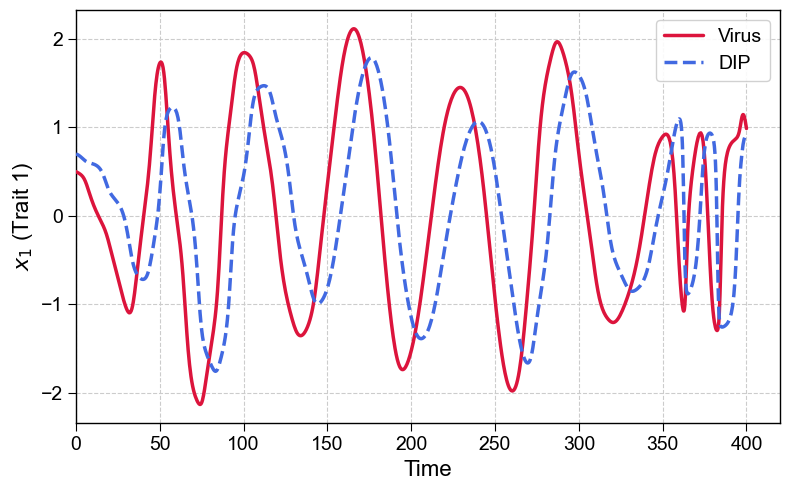

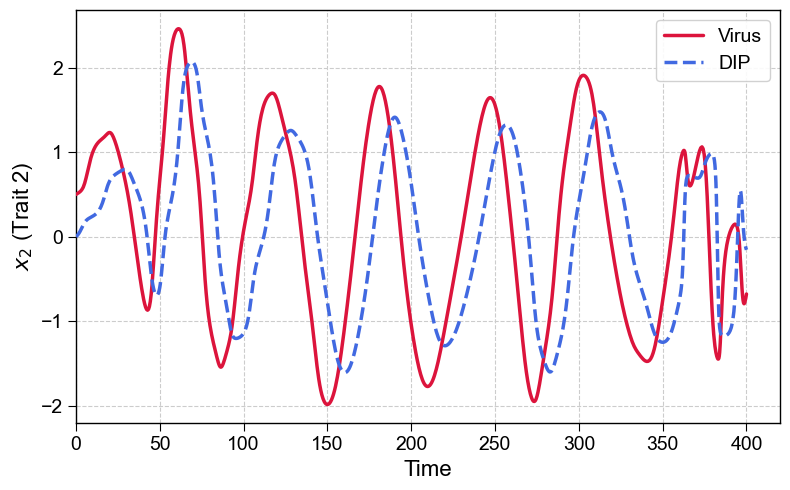

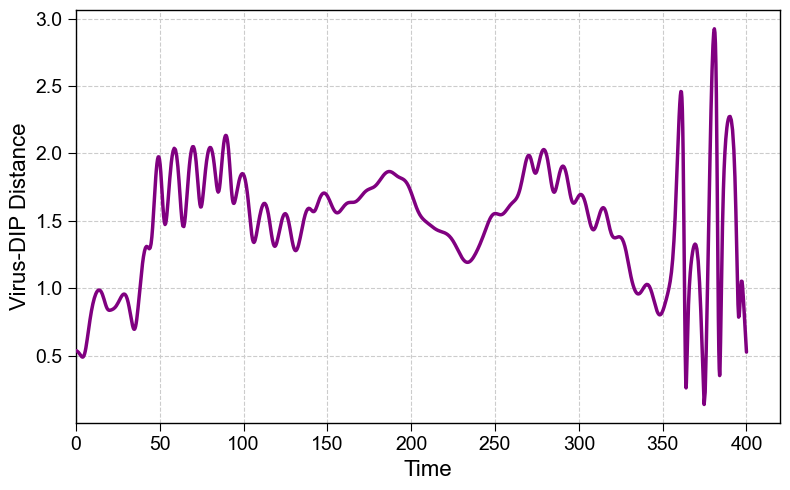

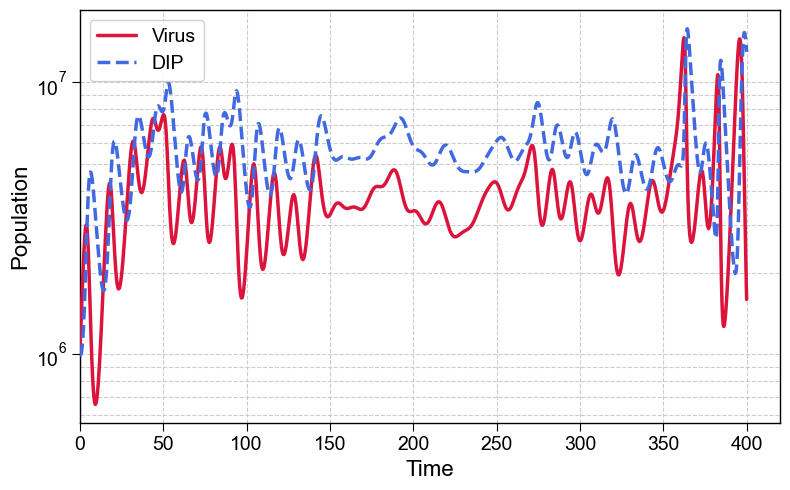

--- Analysis Complete ---


In [8]:

# A base parameter set for a "chase" dynamic
params_chase = {}

# Update parameters for the specific perturbation analysis
params_perturb = copy.deepcopy(params_chase)
params_perturb.update({
    "n_dims": 2,
    "nx": 50, # Grid points per dimension (lower for faster 3D run)
    "bord": 5,
    "T": 400,
    "v_init_pos": [0.5, 0.5],  # Starts on the z=0 plane
    "d_init_pos": [0.7, 0.0], # Starts with a tiny z-offset
})

# Run the updated analysis function, which now saves separate plots
results_2d = run_nd_dynamics_analysis_plot(
    params=params_perturb,
    save_dir=None,
    show_plots=True
    )


--- Running N-Dimensional Dynamics Analysis (saving to 'all_runs/ndim/3D') ---
  Simulating 3D coevolution...
  Simulation finished at t=400.00. Reason: t_end_reached
  Calculating distance metrics...
  Generating and saving individual plots...
    - Saved: dimension_1_vs_time.svg


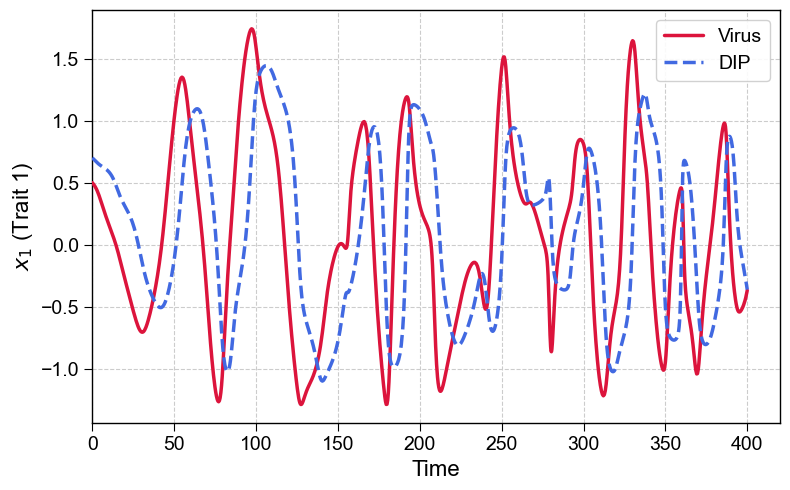

    - Saved: dimension_2_vs_time.svg


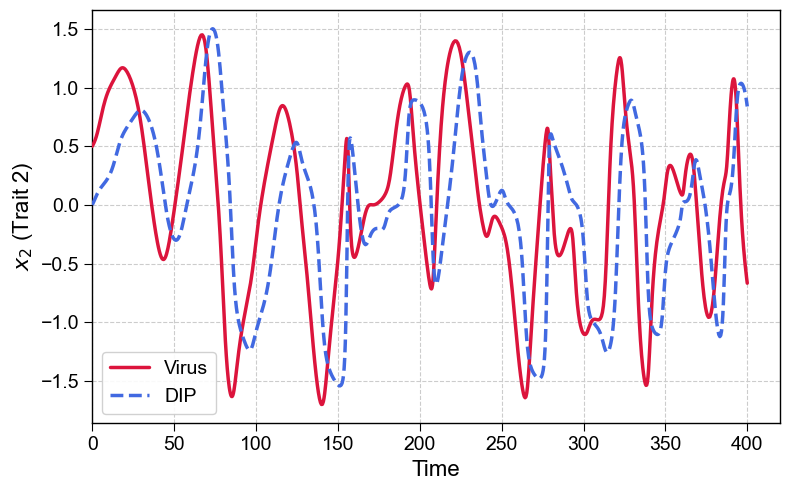

    - Saved: dimension_3_vs_time.svg


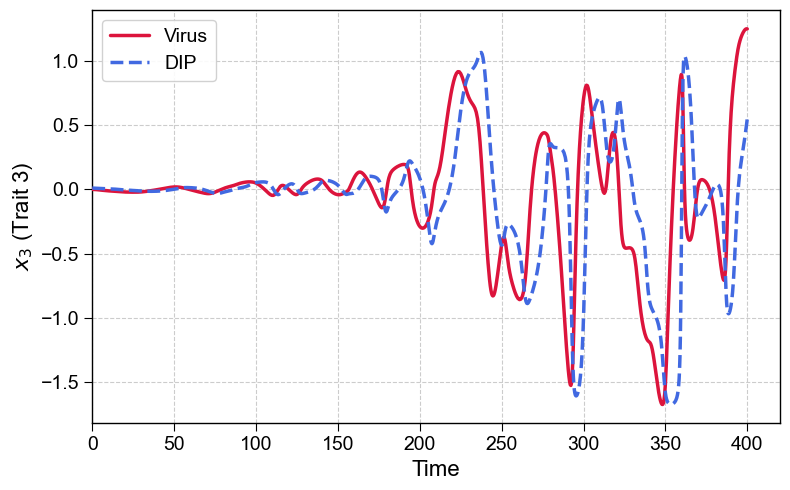

    - Saved: euclidean_distance_vs_time.svg


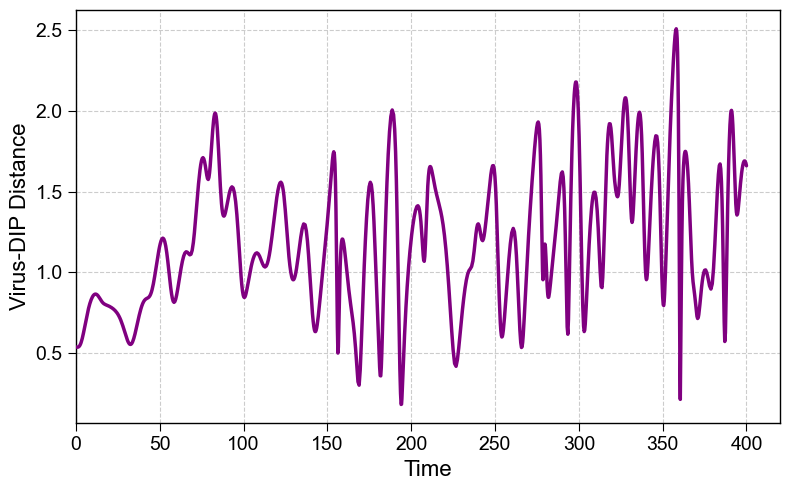

    - Saved: population_vs_time.svg


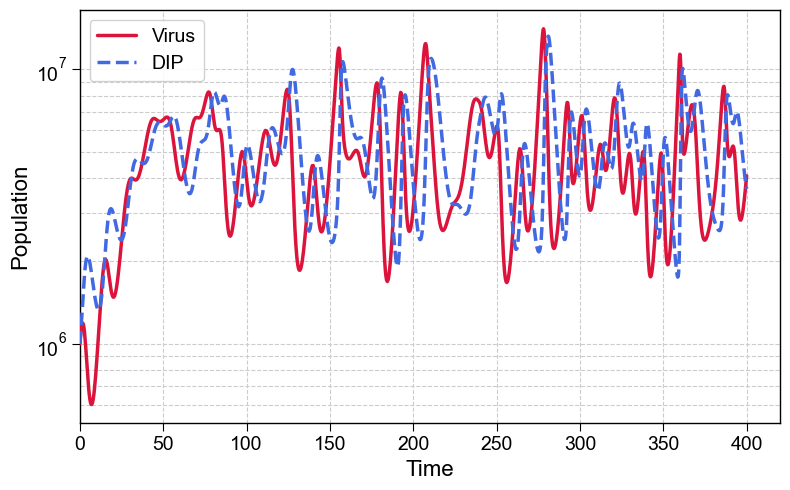

--- Analysis Complete ---


In [9]:

# A base parameter set for a "chase" dynamic
params_chase = {}

# Update parameters for the specific perturbation analysis
params_perturb = copy.deepcopy(params_chase)
params_perturb.update({
    "n_dims": 3,
    "nx": 30, # Grid points per dimension (lower for faster 3D run)
    "bord": 3,
    "T": 400,
    "v_init_pos": [0.5, 0.5, 0.0],  # Starts on the z=0 plane
    "d_init_pos": [0.7, 0.0, 0.01], # Starts with a tiny z-offset
})

# Run the updated analysis function, which now saves separate plots
results_3d = run_nd_dynamics_analysis_plot(
    params=params_perturb,
    save_dir='all_runs/ndim/3D',
    show_plots=True
    )

In [10]:

# A base parameter set for a "chase" dynamic
params_chase = {}

# Parameters for the 4D perturbation analysis
params_4d_perturb = copy.deepcopy(params_chase)
params_4d_perturb.update({
    "n_dims": 4,
    "nx": 24, # Grid points per dim. Lowered because 24^4 is already >300,000 points!
    "bord": 3,
    "T": 400,
    # Start the chase in dims 1 & 2, with new dimensions unperturbed for V
    "v_init_pos": [0.5, 0.5, 0.0, 0.0],
    # Add small, distinct perturbations to the new dimensions for D
    "d_init_pos": [0.7, 0.0, 0.01, -0.01],
})

# Run the new, generalized analysis function for the 4D case
results_4d = run_nd_dynamics_analysis_plot(
    params=params_4d_perturb,
    save_dir="all_runs/ndim/4D",
    show_plots=True
)


--- Running N-Dimensional Dynamics Analysis (saving to 'all_runs/ndim/4D') ---
  Simulating 4D coevolution...


KeyboardInterrupt: 